# Distributed All-Reduce Benchmark (Single Node)

This notebook runs a single-node, multi-process benchmark of the `torch.distributed` `all_reduce` collective.

- Backends: `gloo` (CPU) and `nccl` (GPU, if available)
- Tensor sizes: 1MB, 10MB, 100MB, 1GB (auto-trimmed on GPU if they don't fit)
- World sizes: 2, 4, 6 (GPU runs are skipped if you have fewer GPUs)

The benchmark script lives at `cs336_systems/distributed/allreduce_bench.py` and is launched via `torchrun`.

Quick CLI examples (from repo root):

```bash
# Gloo / CPU, 4 processes
torchrun --standalone --nproc_per_node=4 cs336_systems/distributed/allreduce_bench.py --backend gloo --device cpu --sizes-mb 1,10,100,1000

# NCCL / GPU, 4 processes (requires >=4 GPUs)
torchrun --standalone --nproc_per_node=4 cs336_systems/distributed/allreduce_bench.py --backend nccl --device cuda --sizes-mb 1,10,100,1000
```


In [1]:
import os
import sys
import json
import shlex
import subprocess
from pathlib import Path
from typing import List, Dict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Resolve repo root robustly in Jupyter (no __file__)
CWD = Path.cwd()
# Try a few candidates upwards to find the repo root where cs336_systems/ exists
candidates = [CWD, *list(CWD.parents)]
REPO_ROOT = None
for c in candidates:
    if (c / "cs336_systems" / "distributed").exists():
        REPO_ROOT = c
        break
if REPO_ROOT is None:
    REPO_ROOT = CWD

SCRIPT = REPO_ROOT / "cs336_systems" / "distributed" / "allreduce_bench.py"
OUTPUT_DIR = REPO_ROOT / "runs" / "distributed_bench"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repo root: {REPO_ROOT}")
print(f"Benchmark script: {SCRIPT}")
print(f"Output dir: {OUTPUT_DIR}")


def run_bench(
    backend: str,
    world_size: int,
    sizes_mb: List[int] = [1, 10, 100, 1000],
    iters: int = 30,
    warmup: int = 5,
    dtype: str = "float32",
    extra: str = "",
) -> Path:
    """Run the benchmark via torchrun and save JSONL output.

    Returns path to the JSONL file.
    """
    out_file = OUTPUT_DIR / f"bench_{backend}_ws{world_size}.jsonl"
    sizes_arg = ",".join(str(s) for s in sizes_mb)

    cmd = (
        f"torchrun --standalone --nproc_per_node={world_size} "
        f"{shlex.quote(str(SCRIPT))} --backend {backend} "
        f"--sizes-mb {sizes_arg} --iters {iters} --warmup {warmup} "
        f"--dtype {dtype} --output {shlex.quote(str(out_file))} --quiet"
    )

    print("Running:", cmd)
    env = os.environ.copy()
    # Be explicit for device selection
    if backend == "gloo":
        env["OMP_NUM_THREADS"] = env.get("OMP_NUM_THREADS", "1")
        cmd += " --device cpu"
    else:
        cmd += " --device cuda"

    # Execute
    proc = subprocess.run(cmd, shell=True, cwd=str(REPO_ROOT), env=env)
    if proc.returncode != 0:
        raise RuntimeError(f"Benchmark failed with code {proc.returncode}")
    return out_file


def load_results(paths: List[Path]) -> pd.DataFrame:
    rows: List[Dict] = []
    for p in paths:
        if not p.exists():
            continue
        for line in p.read_text().splitlines():
            try:
                rows.append(json.loads(line))
            except json.JSONDecodeError:
                pass
    df = pd.DataFrame(rows)
    if not df.empty:
        df.sort_values(["backend", "world_size", "size_mb"], inplace=True)
    return df


def plot_results(df: pd.DataFrame):
    if df.empty:
        print("No data to plot")
        return

    display(df)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    sns.lineplot(
        data=df,
        x="size_mb",
        y="mean_ms",
        hue="backend",
        style="world_size",
        markers=True,
        dashes=False,
        ax=axes[0],
    )
    axes[0].set_xscale("log")
    axes[0].set_xlabel("Tensor size (MB)")
    axes[0].set_ylabel("Latency (ms, mean across iters; max across ranks)")
    axes[0].set_title("All-Reduce Latency")

    sns.lineplot(
        data=df,
        x="size_mb",
        y="bandwidth_GBps",
        hue="backend",
        style="world_size",
        markers=True,
        dashes=False,
        ax=axes[1],
    )
    axes[1].set_xscale("log")
    axes[1].set_xlabel("Tensor size (MB)")
    axes[1].set_ylabel("Effective Bandwidth (GB/s per rank)")
    axes[1].set_title("All-Reduce Effective Bandwidth")

    plt.show()


Repo root: /home/ed/work/other_projects/stanLLMasingments/assignment2-systems
Benchmark script: /home/ed/work/other_projects/stanLLMasingments/assignment2-systems/cs336_systems/distributed/allreduce_bench.py
Output dir: /home/ed/work/other_projects/stanLLMasingments/assignment2-systems/runs/distributed_bench


In [2]:
# Configure experiment matrix

world_sizes = [2, 4, 6]
backend_matrix = ["gloo"] + (["nccl"] if torch.cuda.is_available() else [])
# You can adjust the sizes if your GPU memory is limited
sizes_mb = [1, 10, 100, 1000]

result_files = []
for backend in backend_matrix:
    for ws in world_sizes:
        if backend == "nccl":
            num_gpus = torch.cuda.device_count()
            if num_gpus < ws:
                print(f"Skip NCCL ws={ws}: only {num_gpus} GPUs available")
                continue
        try:
            result_files.append(run_bench(backend=backend, world_size=ws, sizes_mb=sizes_mb))
        except Exception as e:
            print(f"Failed run backend={backend} ws={ws}: {e}")

print("Artifacts:")
for p in result_files:
    print(" -", p)


Running: torchrun --standalone --nproc_per_node=2 /home/ed/work/other_projects/stanLLMasingments/assignment2-systems/cs336_systems/distributed/allreduce_bench.py --backend gloo --sizes-mb 1,10,100,1000 --iters 30 --warmup 5 --dtype float32 --output /home/ed/work/other_projects/stanLLMasingments/assignment2-systems/runs/distributed_bench/bench_gloo_ws2.jsonl --quiet
{"backend": "gloo", "device": "cpu", "world_size": 2, "size_mb": 1, "dtype": "float32", "iters": 30, "warmup": 5, "mean_ms": 0.4877861002266097, "p50_ms": 0.4733995083370246, "p95_ms": 0.6019001521053724, "bandwidth_GBps": 2.149663550299743}
{"backend": "gloo", "device": "cpu", "world_size": 2, "size_mb": 10, "dtype": "float32", "iters": 30, "warmup": 5, "mean_ms": 2.9149493318982422, "p50_ms": 2.8971959982300177, "p95_ms": 3.2715683497372083, "bandwidth_GBps": 3.5972357684761453}
{"backend": "gloo", "device": "cpu", "world_size": 2, "size_mb": 100, "dtype": "float32", "iters": 30, "warmup": 5, "mean_ms": 30.54280173431228, 

,backend,device,world_size,size_mb,dtype,iters,warmup,mean_ms,p50_ms,p95_ms,bandwidth_GBps
0,gloo,cpu,2,1,float32,30,5,0.487786,0.473400,0.601900,2.149664
1,gloo,cpu,2,10,float32,30,5,2.914949,2.897196,3.271568,3.597236
2,gloo,cpu,2,100,float32,30,5,30.542802,30.594875,32.460607,3.433136
3,gloo,cpu,2,1000,float32,30,5,292.195475,290.481911,309.212026,3.588611
4,gloo,cpu,4,1,float32,30,5,1.268568,1.214909,1.755917,1.239874
5,gloo,cpu,4,10,float32,30,5,5.566558,5.509879,6.501976,2.825559
6,gloo,cpu,4,100,float32,30,5,65.977574,60.587029,93.076110,2.383937
7,gloo,cpu,4,1000,float32,30,5,522.061386,513.863874,572.757191,3.012795
8,gloo,cpu,6,1,float32,30,5,2.852703,2.847195,3.294756,0.612621
9,gloo,cpu,6,10,float32,30,5,8.840486,8.510780,10.849019,1.976844


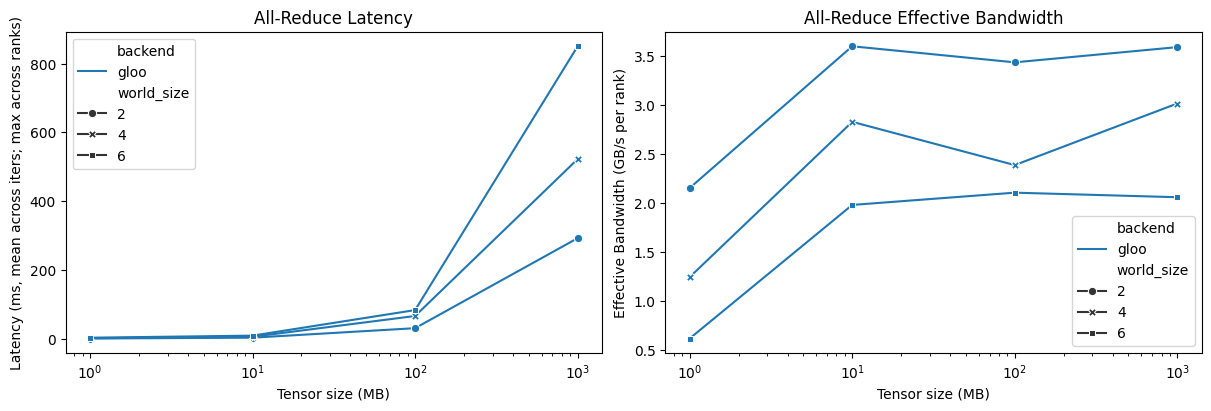

In [3]:
# Load and plot results

df = load_results(result_files)
plot_results(df)
